In [128]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from quantile_forest import RandomForestQuantileRegressor
from sklearn.metrics import mean_pinball_loss


# load data
training_data = pd.read_csv('data/Training_Data_averaged.csv', index_col=0)
testing_data = pd.read_csv('data/Testing_Data_averaged.csv', index_col=0)

training_data_northwest = pd.read_csv('data/Training_Data_Northwest.csv', index_col=0)
testing_data_northwest = pd.read_csv('data/Testing_Data_Northwest.csv', index_col=0)

training_data_southeast = pd.read_csv('data/Training_Data_Southeast.csv', index_col=0)

training_data_southwest = pd.read_csv('data/Training_Data_Southwest.csv', index_col=0)

training_data_northeast = pd.read_csv('data/Training_Data_Northeast.csv', index_col=0)

print(training_data.head())

                          day      hour       msl       tcc       t2m  \
time                                                                    
2019-01-01 00:00:00 -1.727278 -1.661293  1.536836  1.409440 -0.660146   
2019-01-01 01:00:00 -1.727278 -1.516833  1.486795  1.377614 -0.646824   
2019-01-01 02:00:00 -1.727278 -1.372373  1.424867  1.410695 -0.661513   
2019-01-01 03:00:00 -1.727278 -1.227912  1.335549  1.464863 -0.670784   
2019-01-01 04:00:00 -1.727278 -1.083452  1.224283  1.475456 -0.676032   

                         ssr      sund      ws10     ws100  \
time                                                         
2019-01-01 00:00:00 -0.85915 -0.990967  0.825597  0.846255   
2019-01-01 01:00:00 -0.85915 -0.990967  0.980525  0.976528   
2019-01-01 02:00:00 -0.85915 -0.990967  1.147214  1.134154   
2019-01-01 03:00:00 -0.85915 -0.990967  1.353153  1.337304   
2019-01-01 04:00:00 -0.85915 -0.990967  1.551084  1.523818   

                     max Wind Offshore [MW]  max Wind

In [116]:

# make crossvalidation where two years are used for training and one year for testing

def train_model(x,y, x_test, y_test,  quantiles=[0.025, 0.5, 0.975]):
    qrf = RandomForestQuantileRegressor()
    qrf.fit(x, y)
    y_pred = qrf.predict(x_test, quantiles)

    scores = []
    for q_index, q_value in enumerate(quantiles):
        score = mean_pinball_loss(y_true=y_test, y_pred=y_pred[:, q_index], alpha=q_value)
        scores.append(score)

    return np.mean(scores), y_pred


def train_and_predict(cv_combinations, quantiles):
    result_scores = {'offshore': [], 'onshore': [], 'photovoltaic': []}
    predictions = {'offshore': [], 'onshore': [], 'photovoltaic': []}

    for train_data, test_data in cv_combinations:
        # predict wind offshore
        X_offshore = train_data.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]'])
        y_offshore = train_data['Wind Offshore [MW] ']
        X_offshore_test = test_data.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]'])
        y_offshore_test = test_data['Wind Offshore [MW] ']

        # predict wind onshore
        X_onshore = train_data.drop(columns=['year','Wind Onshore [MW]', 'Wind Offshore [MW] ', 'Photovoltaic [MW]'])
        y_onshore = train_data['Wind Onshore [MW]']
        X_onshore_test = test_data.drop(columns=['year','Wind Onshore [MW]', 'Wind Offshore [MW] ', 'Photovoltaic [MW]'])
        y_onshore_test = test_data['Wind Onshore [MW]']

        # predict photovoltaic
        X_photovoltaic = train_data.drop(columns=['year','Photovoltaic [MW]', 'Wind Onshore [MW]', 'Wind Offshore [MW] '])
        y_photovoltaic = train_data['Photovoltaic [MW]']
        X_photovoltaic_test = test_data.drop(columns=['year','Photovoltaic [MW]', 'Wind Onshore [MW]', 'Wind Offshore [MW] '])
        y_photovoltaic_test = test_data['Photovoltaic [MW]']

        # train models
        scores, y_pred_wind_off = train_model(X_offshore, y_offshore, X_offshore_test, y_offshore_test)

        result_scores['offshore'].append(scores)

        y_pred_wind_off = y_pred

        # now onshore
        scores, y_pred_wind_on = train_model(X_onshore, y_onshore, X_onshore_test, y_onshore_test)

        result_scores['onshore'].append(np.mean(scores))

        y_pred_wind_on = y_pred

        # now photovoltaic
        scores, y_pred = train_model(X_photovoltaic, y_photovoltaic, X_photovoltaic_test, y_photovoltaic_test)

        result_scores['photovoltaic'].append(np.mean(scores))

        y_pred_photovoltaic = y_pred
    

    # average results
    result_scores['offshore'] = np.mean(result_scores['offshore'])
    result_scores['onshore'] = np.mean(result_scores['onshore'])
    result_scores['photovoltaic'] = np.mean(result_scores['photovoltaic'])
    print(result_scores)

    predictions['offshore'] = y_pred_wind_off
    predictions['onshore'] = y_pred_wind_on
    predictions['photovoltaic'] = y_pred_photovoltaic

    return result_scores, predictions


    # old [0.3604837916240635, 0.7610238180502263, 0.9064585509229429, 0.351400272413799, 0.8119779727328822, 0.9286052478785203, 0.06681603279290993, 0.7939381342043816, 0.922916477166824]

In [48]:
# predict one hour in the future
#take training data and shift targets by one hour

final_result = {}
prediction_results = {}

training_data_one_hr = training_data.copy()

training_data_one_hr['Wind Offshore [MW] '] = training_data['Wind Offshore [MW] '].shift(-1)
training_data_one_hr['Wind Onshore [MW]'] = training_data['Wind Onshore [MW]'].shift(-1)
training_data_one_hr['Photovoltaic [MW]'] = training_data['Photovoltaic [MW]'].shift(-1)

# drop last row
training_data_one_hr = training_data_one_hr.dropna()

training_data_2019 = training_data_one_hr[training_data_one_hr['year'] == 2019]
training_data_2020 = training_data_one_hr[training_data_one_hr['year'] == 2020]
training_data_2021 = training_data_one_hr[training_data_one_hr['year'] == 2021]

combinations = [
    (pd.concat([training_data_2019, training_data_2020]), training_data_2021),
    (pd.concat([training_data_2019, training_data_2021]), training_data_2020),
    (pd.concat([training_data_2020, training_data_2021]), training_data_2019),
]

quantiles = [0.025, 0.5, 0.975]

final_result['mean_loc_1_hr'], prediction_results['mean_loc_1_hr'] = train_and_predict(combinations, quantiles)

/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without featur

{'offshore': 284.6320595960385, 'onshore': 516.3869097870232, 'photovoltaic': 158.33463951961951}


/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(


In [49]:
# # predict 24 hour in the future
#take training data and shift targets by one hour

training_data_one_day = training_data.copy()

training_data_one_day['Wind Offshore [MW] '] = training_data['Wind Offshore [MW] '].shift(-24)
training_data_one_day['Wind Onshore [MW]'] = training_data['Wind Onshore [MW]'].shift(-24)
training_data_one_day['Photovoltaic [MW]'] = training_data['Photovoltaic [MW]'].shift(-24)

# drop last row
training_data_one_day = training_data_one_day.dropna()

training_data_2019 = training_data_one_day[training_data_one_day['year'] == 2019]
training_data_2020 = training_data_one_day[training_data_one_day['year'] == 2020]
training_data_2021 = training_data_one_day[training_data_one_day['year'] == 2021]

combinations = [
    (pd.concat([training_data_2019, training_data_2020]), training_data_2021),
    (pd.concat([training_data_2019, training_data_2021]), training_data_2020),
    (pd.concat([training_data_2020, training_data_2021]), training_data_2019),
]

final_result['mean_loc_24_hr'], prediction_results['mean_loc_24_hr'] = train_and_predict(combinations, quantiles)


/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without featur

{'offshore': 358.53998983942256, 'onshore': 1396.3385882313753, 'photovoltaic': 256.28549492382507}


/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(


# North West


In [50]:
# predict one hour in the future
#take training data and shift targets by one hour
training_data_one_hr = training_data_northwest.copy()

training_data_one_hr['Wind Offshore [MW] '] = training_data_northwest['Wind Offshore [MW] '].shift(-1)
training_data_one_hr['Wind Onshore [MW]'] = training_data_northwest['Wind Onshore [MW]'].shift(-1)
training_data_one_hr['Photovoltaic [MW]'] = training_data_northwest['Photovoltaic [MW]'].shift(-1)

# drop last row
training_data_one_hr = training_data_one_hr.dropna()

training_data_2019 = training_data_one_hr[training_data_one_hr['year'] == 2019]
training_data_2020 = training_data_one_hr[training_data_one_hr['year'] == 2020]
training_data_2021 = training_data_one_hr[training_data_one_hr['year'] == 2021]

combinations = [
    (pd.concat([training_data_2019, training_data_2020]), training_data_2021),
    (pd.concat([training_data_2019, training_data_2021]), training_data_2020),
    (pd.concat([training_data_2020, training_data_2021]), training_data_2019),
]

final_result['northwest_1_hr'], prediction_results['northwest_1_hr'] = train_and_predict(combinations, quantiles)

/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without featur

{'offshore': 201.79089735211025, 'onshore': 589.4496211173088, 'photovoltaic': 235.24918538925252}


/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(


In [51]:
# # predict 24 hour in the future
#take training data and shift targets by one hour

training_data_one_day = training_data_northwest.copy()

training_data_one_day['Wind Offshore [MW] '] = training_data_northwest['Wind Offshore [MW] '].shift(-24)
training_data_one_day['Wind Onshore [MW]'] = training_data_northwest['Wind Onshore [MW]'].shift(-24)
training_data_one_day['Photovoltaic [MW]'] = training_data_northwest['Photovoltaic [MW]'].shift(-24)

training_data_one_day = training_data_one_day.dropna()

training_data_2019 = training_data_one_day[training_data_one_day['year'] == 2019]
training_data_2020 = training_data_one_day[training_data_one_day['year'] == 2020]
training_data_2021 = training_data_one_day[training_data_one_day['year'] == 2021]

combinations = [
    (pd.concat([training_data_2019, training_data_2020]), training_data_2021),
    (pd.concat([training_data_2019, training_data_2021]), training_data_2020),
    (pd.concat([training_data_2020, training_data_2021]), training_data_2019),
]

final_result['northwest_24_hr'], prediction_results['northwest_24_hr'] = train_and_predict(combinations, quantiles)

/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without featur

{'offshore': 351.0573215130376, 'onshore': 1382.3465991628066, 'photovoltaic': 257.82952987853224}


/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(


# North East


In [52]:
# predict one hour in the future
#take training data and shift targets by one hour
training_data_one_hr = training_data_northeast.copy()

training_data_one_hr['Wind Offshore [MW] '] = training_data_northeast['Wind Offshore [MW] '].shift(-1)
training_data_one_hr['Wind Onshore [MW]'] = training_data_northeast['Wind Onshore [MW]'].shift(-1)
training_data_one_hr['Photovoltaic [MW]'] = training_data_northeast['Photovoltaic [MW]'].shift(-1)

# drop last row
training_data_one_hr = training_data_one_hr.dropna()

training_data_2019 = training_data_one_hr[training_data_one_hr['year'] == 2019]
training_data_2020 = training_data_one_hr[training_data_one_hr['year'] == 2020]
training_data_2021 = training_data_one_hr[training_data_one_hr['year'] == 2021]

combinations = [
    (pd.concat([training_data_2019, training_data_2020]), training_data_2021),
    (pd.concat([training_data_2019, training_data_2021]), training_data_2020),
    (pd.concat([training_data_2020, training_data_2021]), training_data_2019),
]

final_result['northeast_1_hr'], prediction_results['northeast_1_hr'] = train_and_predict(combinations, quantiles)

/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without featur

{'offshore': 287.740591158128, 'onshore': 669.7291730724351, 'photovoltaic': 224.16697554561938}


/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(


In [53]:
# # predict 24 hour in the future
#take training data and shift targets by one hour

training_data_one_day = training_data_northeast.copy()

training_data_one_day['Wind Offshore [MW] '] = training_data_northeast['Wind Offshore [MW] '].shift(-24)
training_data_one_day['Wind Onshore [MW]'] = training_data_northeast['Wind Onshore [MW]'].shift(-24)
training_data_one_day['Photovoltaic [MW]'] = training_data_northeast['Photovoltaic [MW]'].shift(-24)


training_data_one_day = training_data_one_day.dropna()

training_data_2019 = training_data_one_day[training_data_one_day['year'] == 2019]
training_data_2020 = training_data_one_day[training_data_one_day['year'] == 2020]
training_data_2021 = training_data_one_day[training_data_one_day['year'] == 2021]

combinations = [
    (pd.concat([training_data_2019, training_data_2020]), training_data_2021),
    (pd.concat([training_data_2019, training_data_2021]), training_data_2020),
    (pd.concat([training_data_2020, training_data_2021]), training_data_2019),
]

final_result['northeast_24_hr'], prediction_results['northeast_24_hr'] = train_and_predict(combinations, quantiles)

/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without featur

{'offshore': 372.71299104146465, 'onshore': 1506.1329233144113, 'photovoltaic': 264.1941959393716}


/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(


# South West

In [71]:
# predict one hour in the future
#take training data and shift targets by one hour
training_data_one_hr = training_data_southwest.copy()

training_data_one_hr['Wind Offshore [MW] '] = training_data_southwest['Wind Offshore [MW] '].shift(-1)
training_data_one_hr['Wind Onshore [MW]'] = training_data_southwest['Wind Onshore [MW]'].shift(-1)
training_data_one_hr['Photovoltaic [MW]'] = training_data_southwest['Photovoltaic [MW]'].shift(-1)

# drop last row
training_data_one_hr = training_data_one_hr.dropna()

training_data_2019 = training_data_one_hr[training_data_one_hr['year'] == 2019]
training_data_2020 = training_data_one_hr[training_data_one_hr['year'] == 2020]
training_data_2021 = training_data_one_hr[training_data_one_hr['year'] == 2021]

combinations = [
    (pd.concat([training_data_2019, training_data_2020]), training_data_2021),
    (pd.concat([training_data_2019, training_data_2021]), training_data_2020),
    (pd.concat([training_data_2020, training_data_2021]), training_data_2019),
]

final_result['southwest_1_hr'], prediction_results['southwest_1_hr'] = train_and_predict(combinations, quantiles)

/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without featur

{'offshore': 358.3738599456504, 'onshore': 1064.179533052113, 'photovoltaic': 200.44655746523483}


/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(


In [72]:
# # predict 24 hour in the future
#take training data and shift targets by one hour

training_data_one_day = training_data_southwest.copy()

training_data_one_day['Wind Offshore [MW] '] = training_data_southwest['Wind Offshore [MW] '].shift(-24)
training_data_one_day['Wind Onshore [MW]'] = training_data_southwest['Wind Onshore [MW]'].shift(-24)
training_data_one_day['Photovoltaic [MW]'] = training_data_southwest['Photovoltaic [MW]'].shift(-24)

training_data_one_day = training_data_one_day.dropna()

training_data_2019 = training_data_one_day[training_data_one_day['year'] == 2019]
training_data_2020 = training_data_one_day[training_data_one_day['year'] == 2020]
training_data_2021 = training_data_one_day[training_data_one_day['year'] == 2021]

combinations = [
    (pd.concat([training_data_2019, training_data_2020]), training_data_2021),
    (pd.concat([training_data_2019, training_data_2021]), training_data_2020),
    (pd.concat([training_data_2020, training_data_2021]), training_data_2019),
]

final_result['southwest_24_hr'], prediction_results['southwest_24_hr'] = train_and_predict(combinations, quantiles)

/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without featur

{'offshore': 374.6299396545046, 'onshore': 1482.4736879276131, 'photovoltaic': 269.827794826291}


/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(


# South East

In [56]:
# predict one hour in the future
#take training data and shift targets by one hour
training_data_one_hr = training_data_southeast.copy()

training_data_one_hr['Wind Offshore [MW] '] = training_data_southeast['Wind Offshore [MW] '].shift(-1)
training_data_one_hr['Wind Onshore [MW]'] = training_data_southeast['Wind Onshore [MW]'].shift(-1)
training_data_one_hr['Photovoltaic [MW]'] = training_data_southeast['Photovoltaic [MW]'].shift(-1)

# drop last row
training_data_one_hr = training_data_one_hr.dropna()

training_data_2019 = training_data_one_hr[training_data_one_hr['year'] == 2019]
training_data_2020 = training_data_one_hr[training_data_one_hr['year'] == 2020]
training_data_2021 = training_data_one_hr[training_data_one_hr['year'] == 2021]

combinations = [
    (pd.concat([training_data_2019, training_data_2020]), training_data_2021),
    (pd.concat([training_data_2019, training_data_2021]), training_data_2020),
    (pd.concat([training_data_2020, training_data_2021]), training_data_2019),
]

final_result['southeast_1_hr'], prediction_results['southeast_1_hr'] = train_and_predict(combinations, quantiles)

/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without featur

{'offshore': 370.5339724837242, 'onshore': 1172.8541792961742, 'photovoltaic': 204.900454162976}


/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(


In [57]:
# # predict 24 hour in the future
#take training data and shift targets by one hour

training_data_one_day = training_data_southeast.copy()

training_data_one_day['Wind Offshore [MW] '] = training_data_southeast['Wind Offshore [MW] '].shift(-24)
training_data_one_day['Wind Onshore [MW]'] = training_data_southeast['Wind Onshore [MW]'].shift(-24)
training_data_one_day['Photovoltaic [MW]'] = training_data_southeast['Photovoltaic [MW]'].shift(-24)

training_data_one_day = training_data_one_day.dropna()

training_data_2019 = training_data_one_day[training_data_one_day['year'] == 2019]
training_data_2020 = training_data_one_day[training_data_one_day['year'] == 2020]
training_data_2021 = training_data_one_day[training_data_one_day['year'] == 2021]

combinations = [
    (pd.concat([training_data_2019, training_data_2020]), training_data_2021),
    (pd.concat([training_data_2019, training_data_2021]), training_data_2020),
    (pd.concat([training_data_2020, training_data_2021]), training_data_2019),
]

final_result['southeast_24_hr'], prediction_results['southeast_24_hr'] = train_and_predict(combinations, quantiles)

/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without featur

{'offshore': 373.9136843992856, 'onshore': 1650.941451484724, 'photovoltaic': 275.4338427341078}


/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(


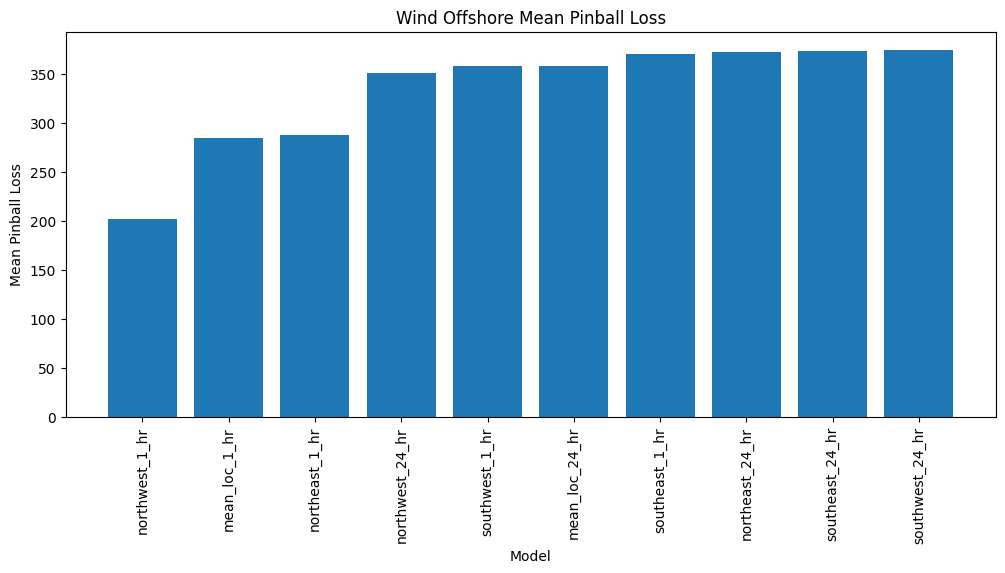

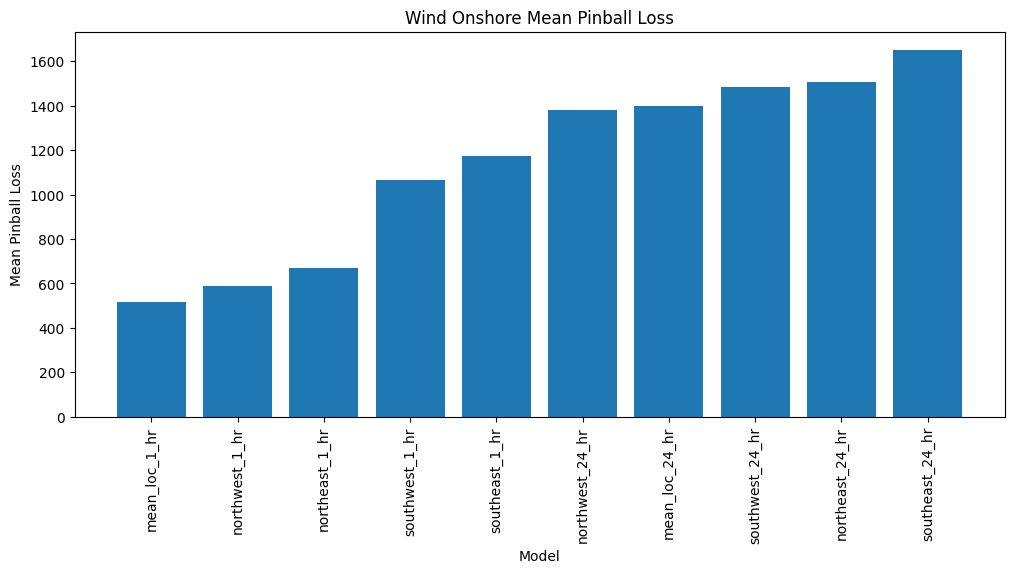

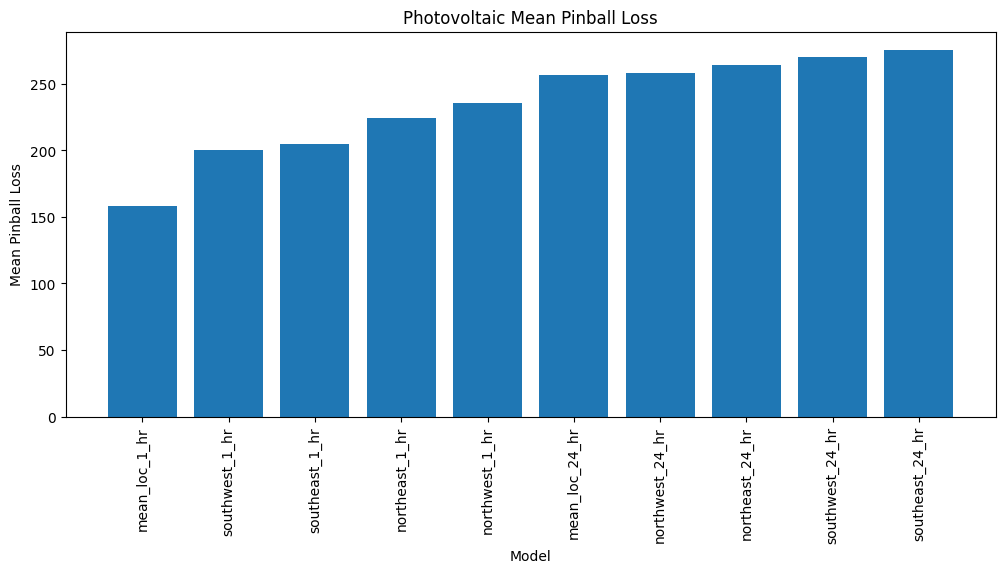

In [91]:
#print(final_result)
#print(prediction_results)

# plot results
df = pd.DataFrame(final_result)
df = df.T
df = df.reset_index()
#df.columns = ['location', 'mean_pinball_loss']

# make df longer for plotting
df = pd.melt(df, id_vars=['index'], value_vars=['offshore', 'onshore', 'photovoltaic'])
df = df.sort_values(by='value')
# make plot for wind offshore
df_wind_offshore = df[df['variable'] == 'offshore']
plt.figure(figsize=(12, 5))
plt.bar(df_wind_offshore['index'], df_wind_offshore['value'])
plt.xticks(rotation=90)
plt.title('Wind Offshore Mean Pinball Loss')
plt.ylabel('Mean Pinball Loss')
plt.xlabel('Model')
plt.show()

df_wind_onshore = df[df['variable'] == 'onshore']
plt.figure(figsize=(12, 5))
plt.bar(df_wind_onshore['index'], df_wind_onshore['value'])
plt.xticks(rotation=90)
plt.title('Wind Onshore Mean Pinball Loss')
plt.ylabel('Mean Pinball Loss')
plt.xlabel('Model')
plt.show()

df_photovoltaic = df[df['variable'] == 'photovoltaic']
plt.figure(figsize=(12, 5))
plt.bar(df_photovoltaic['index'], df_photovoltaic['value'])
plt.xticks(rotation=90)
plt.title('Photovoltaic Mean Pinball Loss')
plt.ylabel('Mean Pinball Loss')
plt.xlabel('Model')
plt.show()


df.to_csv('results/mean_pinball_loss.csv', index=False)


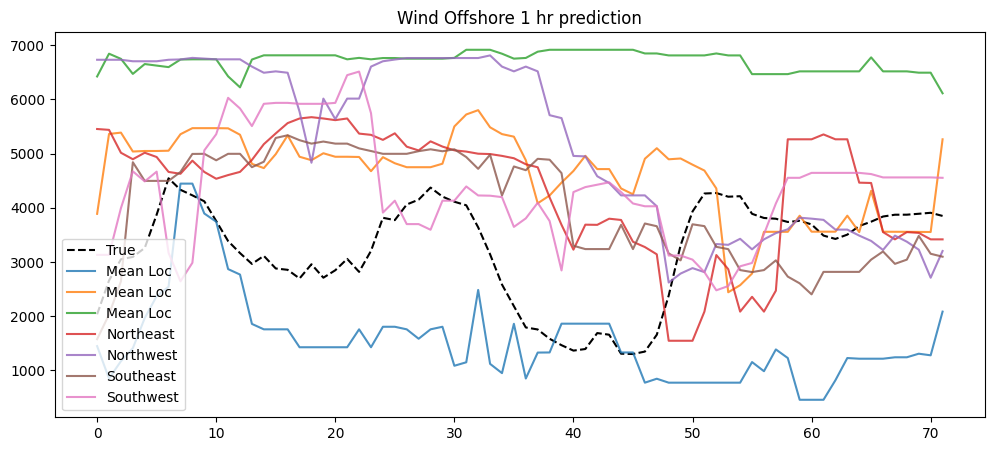

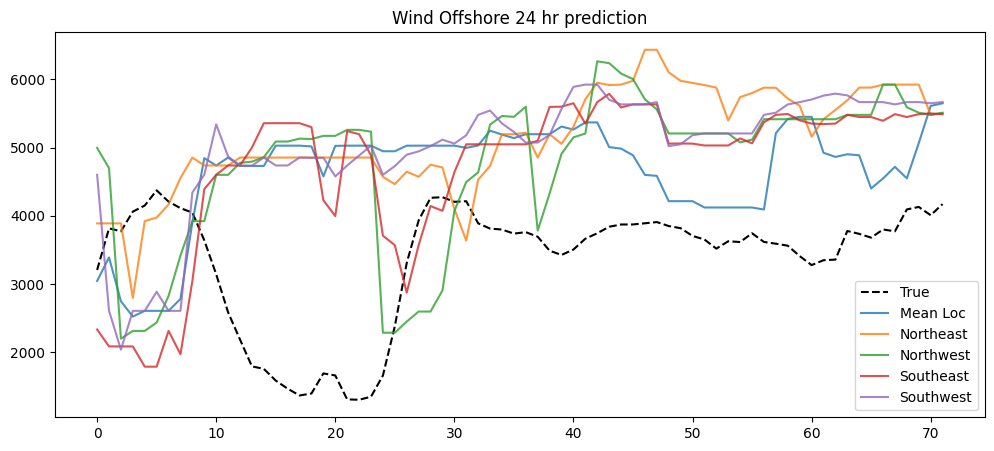

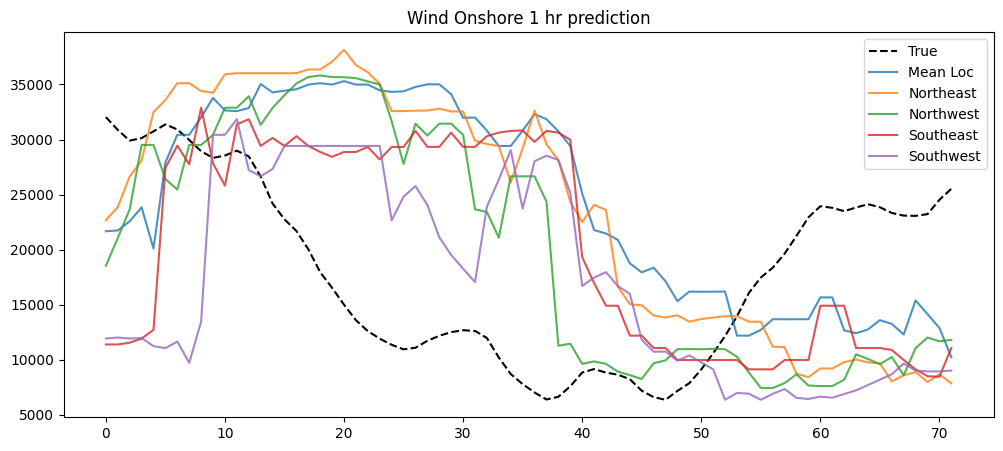

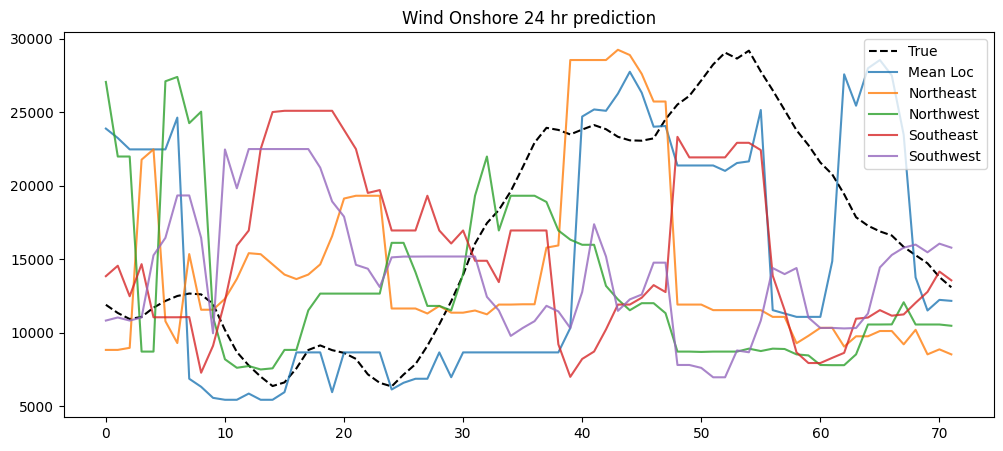

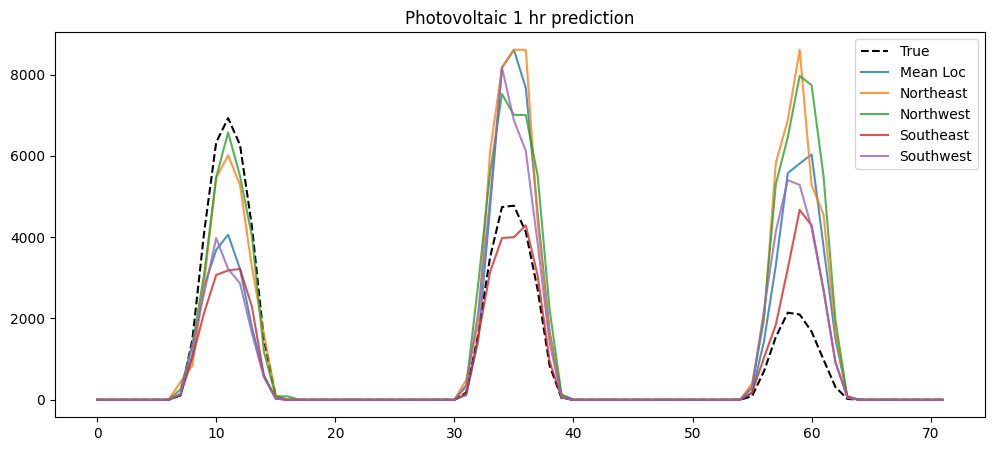

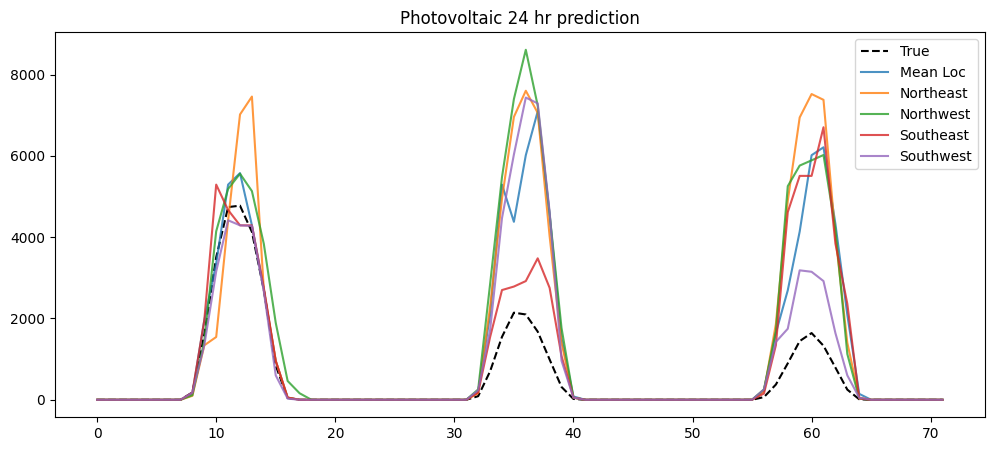

In [102]:

#compare predictions in one ploz for 72 hours

y_offshore_true = training_data_2019['Wind Offshore [MW] '].values
y_onshore_true = training_data_2019['Wind Onshore [MW]'].values
y_photovoltaic_true = training_data_2019['Photovoltaic [MW]'].values

y_offshore_pred_mean_loc_1_hr = prediction_results['mean_loc_1_hr']['offshore']
y_onshore_pred_mean_loc_1_hr = prediction_results['mean_loc_1_hr']['onshore'][:,1]
y_photovoltaic_pred_mean_loc_1_hr = prediction_results['mean_loc_1_hr']['photovoltaic'][:,1]

y_offshore_pred_mean_loc_24_hr = prediction_results['mean_loc_24_hr']['offshore'][:,1]
y_onshore_pred_mean_loc_24_hr = prediction_results['mean_loc_24_hr']['onshore'][:,1]
y_photovoltaic_pred_mean_loc_24_hr = prediction_results['mean_loc_24_hr']['photovoltaic'][:,1]

y_offshore_pred_northwest_1_hr = prediction_results['northwest_1_hr']['offshore'][:,1]
y_onshore_pred_northwest_1_hr = prediction_results['northwest_1_hr']['onshore'][:,1]
y_photovoltaic_pred_northwest_1_hr = prediction_results['northwest_1_hr']['photovoltaic'][:,1]

y_offshore_pred_northwest_24_hr = prediction_results['northwest_24_hr']['offshore'][:,1]
y_onshore_pred_northwest_24_hr = prediction_results['northwest_24_hr']['onshore'][:,1]
y_photovoltaic_pred_northwest_24_hr = prediction_results['northwest_24_hr']['photovoltaic'][:,1]

y_offshore_pred_northeast_1_hr = prediction_results['northeast_1_hr']['offshore'][:,1]
y_onshore_pred_northeast_1_hr = prediction_results['northeast_1_hr']['onshore'][:,1]
y_photovoltaic_pred_northeast_1_hr = prediction_results['northeast_1_hr']['photovoltaic'][:,1]

y_offshore_pred_northeast_24_hr = prediction_results['northeast_24_hr']['offshore'][:,1]
y_onshore_pred_northeast_24_hr = prediction_results['northeast_24_hr']['onshore'][:,1]
y_photovoltaic_pred_northeast_24_hr = prediction_results['northeast_24_hr']['photovoltaic'][:,1]

y_offshore_pred_southwest_1_hr = prediction_results['southwest_1_hr']['offshore'][:,1]
y_onshore_pred_southwest_1_hr = prediction_results['southwest_1_hr']['onshore'][:,1]
y_photovoltaic_pred_southwest_1_hr = prediction_results['southwest_1_hr']['photovoltaic'][:,1]

y_offshore_pred_southwest_24_hr = prediction_results['southwest_24_hr']['offshore'][:,1]
y_onshore_pred_southwest_24_hr = prediction_results['southwest_24_hr']['onshore'][:,1]
y_photovoltaic_pred_southwest_24_hr = prediction_results['southwest_24_hr']['photovoltaic'][:,1]

y_offshore_pred_southeast_1_hr = prediction_results['southeast_1_hr']['offshore'][:,1]
y_onshore_pred_southeast_1_hr = prediction_results['southeast_1_hr']['onshore'][:,1]
y_photovoltaic_pred_southeast_1_hr = prediction_results['southeast_1_hr']['photovoltaic'][:,1]

y_offshore_pred_southeast_24_hr = prediction_results['southeast_24_hr']['offshore'][:,1]
y_onshore_pred_southeast_24_hr = prediction_results['southeast_24_hr']['onshore'][:,1]
y_photovoltaic_pred_southeast_24_hr = prediction_results['southeast_24_hr']['photovoltaic'][:,1]

# make 2 plots, one for 1 hr prediction and one for 24 hr prediction
plt.figure(figsize=(12, 5))
# dashes
plt.plot(y_offshore_true[1:73], label='True', linestyle='--', color='black')
plt.plot(y_offshore_pred_mean_loc_1_hr[:72], alpha= 0.8, label='Mean Loc')
plt.plot(y_offshore_pred_northeast_1_hr[:72], alpha= 0.8, label='Northeast')
plt.plot(y_offshore_pred_northwest_1_hr[:72], alpha= 0.8, label='Northwest')
plt.plot(y_offshore_pred_southeast_1_hr[:72], alpha= 0.8, label='Southeast')
plt.plot(y_offshore_pred_southwest_1_hr[:72], alpha= 0.8, label='Southwest')
plt.title('Wind Offshore 1 hr prediction')
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(y_offshore_true[24:96], label='True', linestyle='--', color='black')
plt.plot(y_offshore_pred_mean_loc_24_hr[:72], alpha= 0.8, label='Mean Loc')
plt.plot(y_offshore_pred_northeast_24_hr[:72], alpha= 0.8, label='Northeast')
plt.plot(y_offshore_pred_northwest_24_hr[:72], alpha= 0.8, label='Northwest')
plt.plot(y_offshore_pred_southeast_24_hr[:72], alpha= 0.8, label='Southeast')
plt.plot(y_offshore_pred_southwest_24_hr[:72], alpha= 0.8, label='Southwest')
plt.title('Wind Offshore 24 hr prediction')
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(y_onshore_true[1:73], label='True', linestyle='--', color='black')
plt.plot(y_onshore_pred_mean_loc_1_hr[:72], alpha= 0.8, label='Mean Loc')
plt.plot(y_onshore_pred_northeast_1_hr[:72], alpha= 0.8, label='Northeast')
plt.plot(y_onshore_pred_northwest_1_hr[:72], alpha= 0.8, label='Northwest')
plt.plot(y_onshore_pred_southeast_1_hr[:72], alpha= 0.8, label='Southeast')
plt.plot(y_onshore_pred_southwest_1_hr[:72], alpha= 0.8, label='Southwest')
plt.title('Wind Onshore 1 hr prediction')
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(y_onshore_true[24:96], label='True', linestyle='--', color='black')
plt.plot(y_onshore_pred_mean_loc_24_hr[:72], alpha= 0.8, label='Mean Loc')
plt.plot(y_onshore_pred_northeast_24_hr[:72], alpha= 0.8, label='Northeast')
plt.plot(y_onshore_pred_northwest_24_hr[:72], alpha= 0.8, label='Northwest')
plt.plot(y_onshore_pred_southeast_24_hr[:72], alpha= 0.8, label='Southeast')
plt.plot(y_onshore_pred_southwest_24_hr[:72], alpha= 0.8, label='Southwest')
plt.title('Wind Onshore 24 hr prediction')
plt.legend()

plt.show()

plt.figure(figsize=(12, 5))
plt.plot(y_photovoltaic_true[1:73], label='True', linestyle='--', color='black')
plt.plot(y_photovoltaic_pred_mean_loc_1_hr[:72], alpha= 0.8, label='Mean Loc')
plt.plot(y_photovoltaic_pred_northeast_1_hr[:72], alpha= 0.8, label='Northeast')
plt.plot(y_photovoltaic_pred_northwest_1_hr[:72], alpha= 0.8, label='Northwest')
plt.plot(y_photovoltaic_pred_southeast_1_hr[:72], alpha= 0.8, label='Southeast')
plt.plot(y_photovoltaic_pred_southwest_1_hr[:72], alpha= 0.8, label='Southwest')
plt.title('Photovoltaic 1 hr prediction')
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(y_photovoltaic_true[24:24+72], label='True', linestyle='--', color='black')
plt.plot(y_photovoltaic_pred_mean_loc_24_hr[:72], alpha= 0.8, label='Mean Loc')
plt.plot(y_photovoltaic_pred_northeast_24_hr[:72], alpha= 0.8, label='Northeast')
plt.plot(y_photovoltaic_pred_northwest_24_hr[:72], alpha= 0.8, label='Northwest')
plt.plot(y_photovoltaic_pred_southeast_24_hr[:72], alpha= 0.8, label='Southeast')
plt.plot(y_photovoltaic_pred_southwest_24_hr[:72], alpha= 0.8, label='Southwest')
plt.title('Photovoltaic 24 hr prediction')
plt.legend()
plt.show()


# based on these results, will now predict on the test data

using the following training data:
- wind offshore 1hr: northwest
- wind offshore 24hrs: northwest
- wind onshore 1hr: mean
- wind onshore 24hrs: northwest
- photovoltaic 1 hr: mean
- photovoltaic 24hrs: mean

The models will train on the whole 3 years now and will be tested on the 2022 dataset

In [132]:
training_data_one_hr_mean = training_data.copy()
training_data_one_hr_nw = training_data_northwest.copy()

training_data_one_hr_mean['Wind Offshore [MW] '] = training_data['Wind Offshore [MW] '].shift(-1)
training_data_one_hr_mean['Wind Onshore [MW]'] = training_data['Wind Onshore [MW]'].shift(-1)
training_data_one_hr_mean['Photovoltaic [MW]'] = training_data['Photovoltaic [MW]'].shift(-1)
training_data_one_hr_mean = training_data_one_hr.dropna()

training_data_one_hr_nw['Wind Offshore [MW] '] = training_data_northwest['Wind Offshore [MW] '].shift(-1)
training_data_one_hr_nw['Wind Onshore [MW]'] = training_data_northwest['Wind Onshore [MW]'].shift(-1)
training_data_one_hr_nw['Photovoltaic [MW]'] = training_data_northwest['Photovoltaic [MW]'].shift(-1)
training_data_one_hr_nw = training_data_one_hr_nw.dropna()


testing_data_one_hr = testing_data.copy()

testing_data_one_hr['Wind Offshore [MW] '] = testing_data['Wind Offshore [MW] '].shift(-1)
testing_data_one_hr['Wind Onshore [MW]'] = testing_data['Wind Onshore [MW]'].shift(-1)
testing_data_one_hr['Photovoltaic [MW]'] = testing_data['Photovoltaic [MW]'].shift(-1)# drop last row
testing_data_one_hr = testing_data_one_hr.dropna()

# 24 hrs
training_data_one_day_mean = training_data.copy()
training_data_one_day_nw = training_data_northwest.copy()

training_data_one_day_mean['Wind Offshore [MW] '] = training_data['Wind Offshore [MW] '].shift(-24)
training_data_one_day_mean['Wind Onshore [MW]'] = training_data['Wind Onshore [MW]'].shift(-24)
training_data_one_day_mean['Photovoltaic [MW]'] = training_data['Photovoltaic [MW]'].shift(-24)

training_data_one_day_nw['Wind Offshore [MW] '] = training_data_northwest['Wind Offshore [MW] '].shift(-24)
training_data_one_day_nw['Wind Onshore [MW]'] = training_data_northwest['Wind Onshore [MW]'].shift(-24)
training_data_one_day_nw['Photovoltaic [MW]'] = training_data_northwest['Photovoltaic [MW]'].shift(-24)

testing_data_one_day = testing_data.copy()

testing_data_one_day['Wind Offshore [MW] '] = testing_data['Wind Offshore [MW] '].shift(-24)
testing_data_one_day['Wind Onshore [MW]'] = testing_data['Wind Onshore [MW]'].shift(-24)
testing_data_one_day['Photovoltaic [MW]'] = testing_data['Photovoltaic [MW]'].shift(-24)

# drop last rows
training_data_one_day_mean = training_data_one_day_mean.dropna()
training_data_one_day_nw = training_data_one_day_nw.dropna()
testing_data_one_day = testing_data_one_day.dropna()






In [135]:
# wind offshore
loss_2022 = {}
predictions_2022 = {}

X_offshore = training_data_one_hr_nw.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]'])
y_offshore = training_data_one_hr_nw['Wind Offshore [MW] ']

X_offshore_test = testing_data_one_hr.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]'])
y_offshore_test = testing_data_one_hr['Wind Offshore [MW] ']

scores, y_pred = train_model(X_offshore, y_offshore, X_offshore_test, y_offshore_test)

print('Wind Offshore 1 hr prediction')
print(scores)

loss_2022['offshore_1_hr'] = scores
predictions_2022['offshore_1_hr'] = y_pred

# wind offshore 24 hrs
X_offshore = training_data_one_day_nw.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]'])
y_offshore = training_data_one_day_nw['Wind Offshore [MW] ']

X_offshore_test = testing_data_one_day.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]'])
y_offshore_test = testing_data_one_day['Wind Offshore [MW] ']

scores, y_pred = train_model(X_offshore, y_offshore, X_offshore_test, y_offshore_test)

print('Wind Offshore 24 hr prediction')
print(scores)

loss_2022['offshore_24_hr'] = scores
predictions_2022['offshore_24_hr'] = y_pred

# wind onshore
X_onshore = training_data_one_hr_mean.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]'])
y_onshore = training_data_one_hr_mean['Wind Onshore [MW]']

X_onshore_test = testing_data_one_hr.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]'])
y_onshore_test = testing_data_one_hr['Wind Onshore [MW]']

scores, y_pred = train_model(X_onshore, y_onshore, X_onshore_test, y_onshore_test)

print('Wind Onshore 1 hr prediction')
print(scores)

loss_2022['onshore_1_hr'] = scores
predictions_2022['onshore_1_hr'] = y_pred


# wind onshore 24 hrs
X_onshore = training_data_one_day_nw.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]'])
y_onshore = training_data_one_day_nw['Wind Onshore [MW]']

X_onshore_test = testing_data_one_day.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]'])
y_onshore_test = testing_data_one_day['Wind Onshore [MW]']

scores, y_pred = train_model(X_onshore, y_onshore, X_onshore_test, y_onshore_test)

print('Wind Onshore 24 hr prediction')
print(scores)

loss_2022['onshore_24_hr'] = scores
predictions_2022['onshore_24_hr'] = y_pred

# photovoltaic
X_photovoltaic = training_data_one_hr_mean.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]'])
y_photovoltaic = training_data_one_hr_mean['Photovoltaic [MW]']

X_photovoltaic_test = testing_data_one_hr.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]'])
y_photovoltaic_test = testing_data_one_hr['Photovoltaic [MW]']

scores, y_pred = train_model(X_photovoltaic, y_photovoltaic, X_photovoltaic_test, y_photovoltaic_test)

print('Photovoltaic 1 hr prediction')
print(scores)

loss_2022['photovoltaic_1_hr'] = scores

predictions_2022['photovoltaic_1_hr'] = y_pred

# photovoltaic 24 hrs

X_photovoltaic = training_data_one_day_mean.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]'])
y_photovoltaic = training_data_one_day_mean['Photovoltaic [MW]']

X_photovoltaic_test = testing_data_one_day.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]'])
y_photovoltaic_test = testing_data_one_day['Photovoltaic [MW]']

scores, y_pred = train_model(X_photovoltaic, y_photovoltaic, X_photovoltaic_test, y_photovoltaic_test)

print('Photovoltaic 24 hr prediction')
print(scores)

loss_2022['photovoltaic_24_hr'] = scores
predictions_2022['photovoltaic_24_hr'] = y_pred






/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(


Wind Offshore 1 hr prediction
252.74498614520311


/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(


Wind Offshore 24 hr prediction
305.58352803175563


/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(


Wind Onshore 1 hr prediction
815.0404981542794


/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(


Wind Onshore 24 hr prediction
1309.7994392933458


/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(


Photovoltaic 1 hr prediction
256.17357086282686
Photovoltaic 24 hr prediction
323.2568325511295


/home/lotta/apps/anaconda3/envs/mlre/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(


In [138]:
# now put wind on and offshore together
# wind true

testing_data_one_hr_wind_total = testing_data_one_hr['Wind Offshore [MW] '] + testing_data_one_hr['Wind Onshore [MW]']
predicted_wind_total_1_hr = predictions_2022['offshore_1_hr'] + predictions_2022['onshore_1_hr']

scores = []
for q_index, q_value in enumerate(quantiles):
    score = mean_pinball_loss(y_true=testing_data_one_hr_wind_total, y_pred=predicted_wind_total_1_hr[:, q_index], alpha=q_value)
    scores.append(score)

print('Wind 1 hr prediction')
print(np.mean(score))

loss_2022['wind_total_1_hr'] = scores

# wind true 24hrs
testing_data_one_day_wind_total = testing_data_one_day['Wind Offshore [MW] '] + testing_data_one_day['Wind Onshore [MW]']
predicted_wind_total_24_hr = predictions_2022['offshore_24_hr'] + predictions_2022['onshore_24_hr']

scores = []
for q_index, q_value in enumerate(quantiles):
    score = mean_pinball_loss(y_true=testing_data_one_day_wind_total, y_pred=predicted_wind_total_24_hr[:, q_index], alpha=q_value)
    scores.append(score)

print('Wind 24 hr prediction')
print(scores)

loss_2022['wind_total_24_hr'] = scores


Wind 1 hr prediction
[245.0223574501941, 2039.82243977623, 353.89577914502246]
Wind 24 hr prediction
[349.8376953482715, 3515.340845352564, 601.237100915036]
